In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas

# Сегодня в выборке
400 фотографий лиц. Всяких.

In [51]:
faces.data.shape

(400, 4096)

In [47]:
faces = fetch_olivetti_faces()

In [2]:
from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces().images

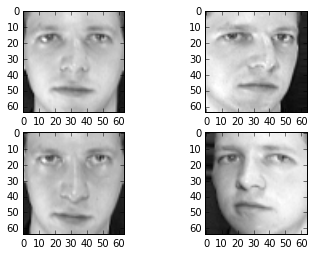

In [3]:
#Ещё одна прикольная фича matplotlib - subplot - можно делать составной график из нескольких простых
#Синтаксис - plt.subplot(число_ячеек_в_высоту, число_ячеек_в_ширину, порядковый_номер_ячейки)
plt.subplot(2,2,1)
plt.imshow(data[0],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(data[1],cmap='gray')
plt.subplot(2,2,3)
plt.imshow(data[2],cmap='gray')
plt.subplot(2,2,4)
plt.imshow(data[3],cmap='gray')

# X,y

Для начала попытаемся по левой половине лица предсказывать правую. В первую очередь для этого нужно нарезать данные на "известные" (левая половина) и "целевые" (правая половина). Исторически сложилось так, что известные данные обычно зовут X, а целевые - y, но здесь нет никакого глубокого смысла.

* Подсказка - вырезать часть данных можно при помощи slice-ов.
* В обычном питоне если у нас есть массив a, то a[2:5] - элементы a под индексами 2,3,4
* Сейчас у вас есть трёхмерный numpy-массив, и slice-ы можно делать по отдельным размерностям.

Размерности data отвечают за (номер картинки, высота, ширина).
* `data[:10]` - первые 10 картинок целиком
* `data[:, :10]` - горизонтальная полоска высотой 10 пикселей наверху изображения - для всех картинок
* `data[10:20, :, :10]` - взять картинки __10~19__ и отрезать от них слева ВЕРТИКАЛЬНУЮ полосу __во всю высоту изображения__ шириной в __10 пикселей__

Попробуйте разные разрезы и посмотрите, что получится.


In [4]:
#отрезаем правую половину лица в Y, левую можно использовать как X
X = data[:,:,:32]
y = data[:,:,32:]

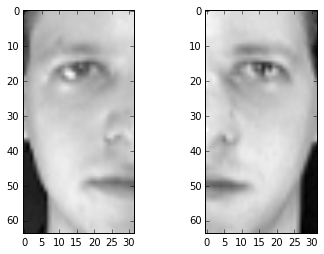

In [5]:
#Если вы всё сделали правильно, тут должно отрисоваться лицо, разрезанное на 2 графика, 
#причём левая половина должна быть слева, а правая - справа
plt.subplot(1,2,1)
plt.imshow(X[0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y[0],cmap='gray')

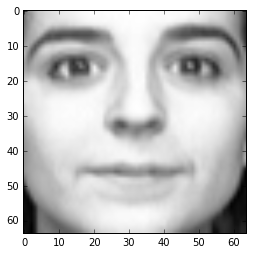

In [6]:
def glue(left_half,right_half):
    #склеить фото лица из 2 половинок
    left_half = left_half.reshape([-1,64,32])
    right_half = right_half.reshape([-1,64,32])
    return np.concatenate([left_half,right_half],axis=-1)

plt.imshow(glue(X,y)[99],cmap='gray')

# Model

In [7]:
from sklearn.cross_validation import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X.reshape([len(X),-1]),
                                                 y.reshape([len(y),-1]),
                                                 test_size=0.05,random_state=42)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
X_test.shape

(20, 2048)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
model = LinearRegression()
model.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
from sklearn.metrics import mean_squared_error, accuracy_score

print(mean_squared_error(Y_train,model.predict(X_train)))
print(mean_squared_error(Y_test,model.predict(X_test)))

2.60531e-13
0.010284


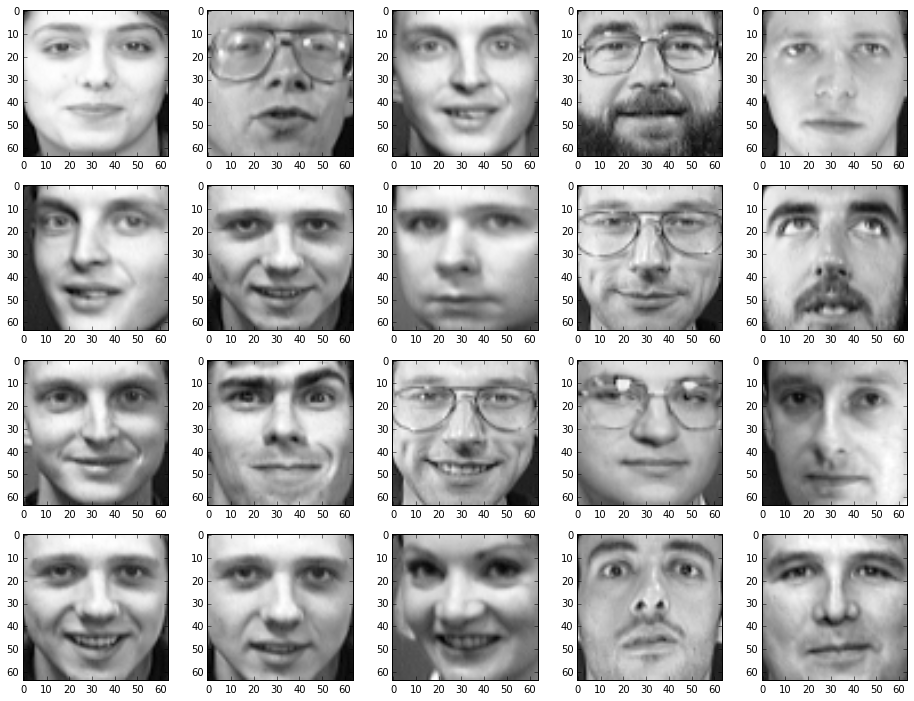

In [11]:
#Картинки на train
pics = glue(X_train,model.predict(X_train))
plt.figure(figsize=[16,12])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(pics[i],cmap='gray')

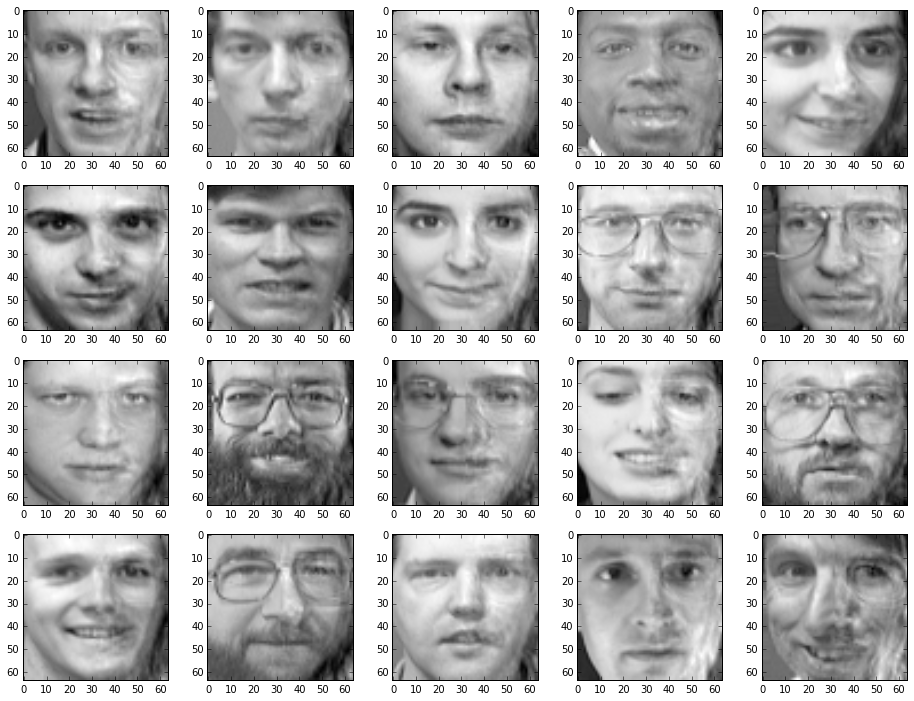

In [12]:
#Картинки на test
pics = glue(X_test,model.predict(X_test))
plt.figure(figsize=[16,12])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(pics[i],cmap='gray')

In [14]:
import lasagne
from lasagne.layers import *

In [26]:
import theano
import theano.tensor as T

In [64]:
x = T.matrix("inp", 'float64')
y = T.matrix("outp", 'float64')

inp = InputLayer((None, 64*32), input_var=x)

r = ReshapeLayer(inp, (-1,1,64,32))
c1 = Conv2DLayer(r, 10, (4,4), (3,3), nonlinearity=T.nnet.sigmoid)
c1 = Conv2DLayer(c1, 5, (4,4), (3,3), nonlinearity=T.nnet.sigmoid)

d1 = ReshapeLayer(c1, (-1,90))
out = DenseLayer(d1, 64*32, nonlinearity=T.nnet.sigmoid)

result = get_output(out)

loss = ((result - y) ** 2 / 2).mean() # mse

w = get_all_params(out)

regularization = lasagne.regularization.regularize_network_params(out, lasagne.regularization.l2)

updates = lasagne.updates.adam(loss + regularization, w)

fit = theano.function([x,y], loss, updates= updates)
predict = theano.function([x], result)

In [65]:
from tqdm import tnrange

In [66]:
from IPython.display import clear_output

l = []

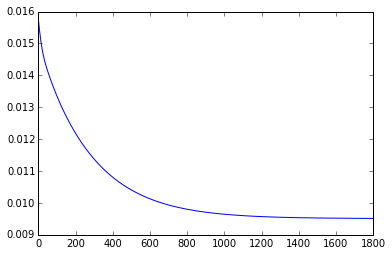

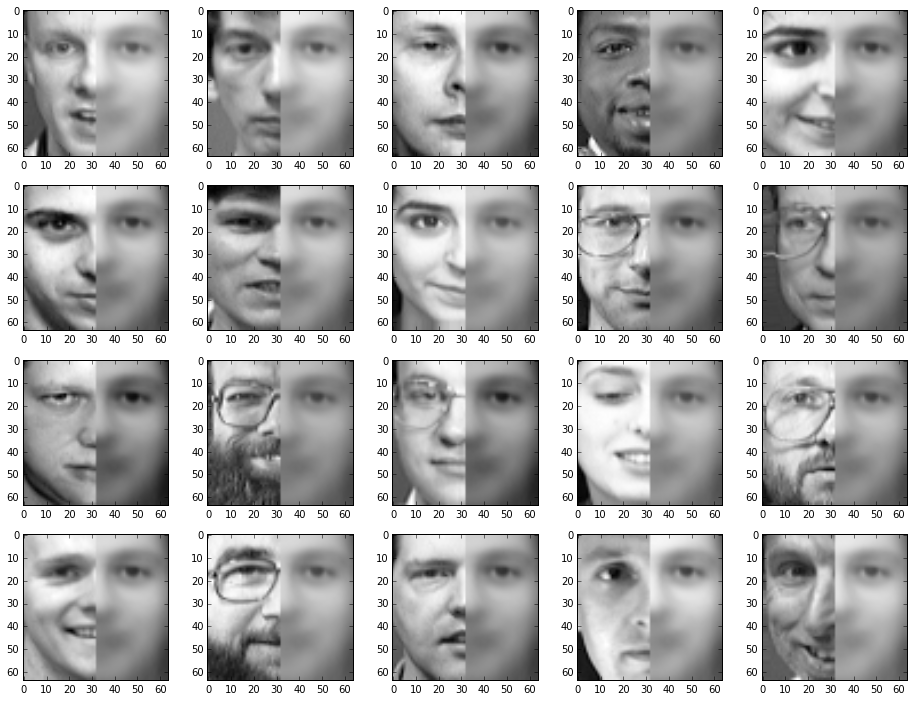

KeyboardInterrupt: 

In [67]:


for i in tnrange(10000):
    l.append(fit(X_train,Y_train))
    
    if i % 100 == 0:
        clear_output(True)
        plt.plot(l)
        plt.show()
        #Картинки на test
        pics = glue(X_test,predict(X_test))
        plt.figure(figsize=[16,12])
        for i in range(20):
            plt.subplot(4,5,i+1)
            plt.imshow(pics[i],cmap='gray')
        plt.show()

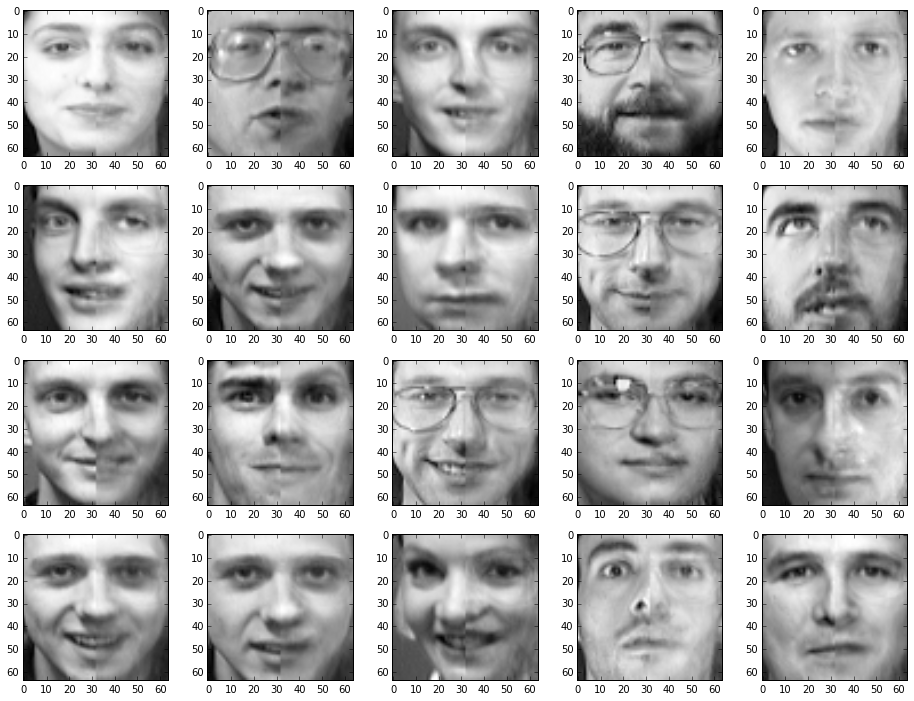

In [63]:
pics = glue(X_train,predict(X_train))
plt.figure(figsize=[16,12])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(pics[i],cmap='gray')

# Ridge regression
Ridge - это как LinearRegression, но с L2 регуляризацией (штраф за сумму квадратов весов

* Квест - попробуйте научить Ridge с параметрами по умолчанию и посмотреть, чем будет отличаться результат.
* Попробуйте подёргать параметр alpha (вес регуляризации) и посмотрите, как меняется результат.

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

#model =  Ridge(alpha=0.5)
model = RandomForestRegressor(n_estimators = 30, max_depth=100)
#MLPRegressor((40,20,40), activation="logistic",verbose=1, tol=1e-7)
#пример создания с alpha = 0.5:  Ridge(alpha=0.5)

In [ ]:
model.fit(X_train,Y_train,)

In [16]:

print(mean_squared_error(Y_train,model.predict(X_train)))
print(mean_squared_error(Y_test,model.predict(X_test)))

0.000423057
0.00802957


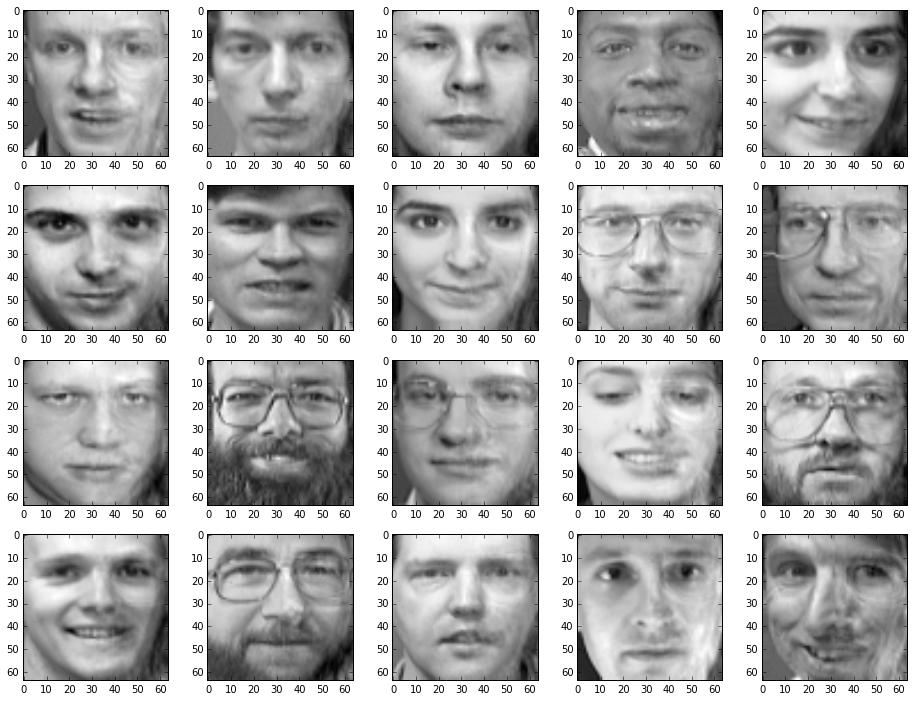

In [17]:
#Картинки на test
pics = glue(X_test,model.predict(X_test))
plt.figure(figsize=[16,12])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(pics[i],cmap='gray')

# Grid search

Найдите параметр alpha такой, что среднеквадратичная ошибка на тесте наименьшая. Постройте зависимость ошибки от alpha.

# Titanic
Давайте попробуем воспользоваться методами машинного обучения, чтобы предсказать выживших на титанике

In [ ]:
from sklearn.preprocessing import LabelEncoder
sex_encode =   LabelEncoder()
em_encode =   LabelEncoder()
def preproc_titanic(data):
    'Функция, которая по исходным данным строит X (удаляет строки, кодирует пол и т. д.)'
    X_titanic = data.copy()
    X_titanic.Embarked[X_titanic.Embarked.isnull()] = 'N'
    le = LabelEncoder()
    X_titanic.Embarked = em_encode.transform(X_titanic.Embarked)
    X_titanic.Sex = sex_encode.transform(X_titanic.Sex)
    X_titanic.Age[X_titanic.Age.isnull()] = 0 
    X_titanic.Fare[X_titanic.Fare.isnull()] = 0
    del X_titanic['Name']
    del X_titanic['Ticket']
    del X_titanic['Cabin']
    return X_titanic

In [ ]:
data = pandas.DataFrame.from_csv("titanic/train.csv")
test_data = pandas.DataFrame.from_csv("titanic/test.csv")

In [ ]:
#LabelEncoder преобразует классы в числа. Научим его преобразовывать пол и порт в конкретные числа
data.Embarked[data.Embarked.isnull()] = 'N'
em_encode.fit(data.Embarked)
sex_encode.fit(data.Sex)

In [ ]:
#Приготовим данные для обучения
X_titanic = preproc_titanic(data)
Y_titanic = data.Survived
del X_titanic['Survived']    

In [ ]:
#Приготовим данные для теста
X_test = preproc_titanic(test_data)

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(X_titanic,
                                                 Y_titanic,
                                                 test_size=0.05,random_state=42)

In [ ]:
model = <выбери алгоритм>
<научи модель>

In [ ]:
#Посчитаем accuracy на ваоидации и на кросс-валидации
print(accuracy_score(Y_val, model.predict(X_val)))
print(cross_val_score(model, X_titanic, Y_titanic).mean())

In [ ]:
Y_test = pandas.DataFrame(index=X_test.index)
Y_test['Survived'] = <предскажи>

In [ ]:
#Сохраним попытку
Y_test.to_csv('mysubmission.csv')

In [ ]:
#Визуализируем дерево решений
from sklearn.externals.six import StringIO  
import pydot
from IPython.display import Image  
dot_data = StringIO()  
export_graphviz(model, out_file=dot_data,  
                         feature_names=X_titanic.columns.values,  
                         class_names=['0', '1'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
graph.write_png('titanic.png')
Image(graph.create_png())